<h1 align="center">Volume 1: Facial Recognition.</h1>

    Maxwell Nielsen
    Section 001
    11/29/2021

In [1]:
import os
import numpy as np
from imageio import imread
from scipy import linalg as la
from matplotlib import pyplot as plt, rcParams
%matplotlib inline

### Helper Functions

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))
        

### Problem 1 

- Implement `show()`.
- Use `show()` to display a face from the `faces94` dataset.

In [3]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    
    orig_image = np.reshape(image, (m,n))      #reshape the image array to its original dimensions
    
    if orig_image.ndim < 3:    #show the image in gray if the image array is less than three dimensions
        plt.imshow(orig_image, cmap="gray")
        plt.axis("off")
    else:                       #show the image in color otherwise
        plt.imshow(orig_image)
        plt.axis("off")
    

This is the face at index 10


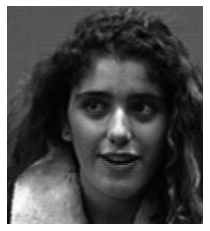

In [4]:
f = get_faces()     #construct F from the get_faces function
pie = f[:, 10]      #choose a face at a certain index
print("This is the face at index 10")
show(pie)        #use our show funtion to show the face

In [5]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces(path)         #create the matrix F using the get_faces function
        
        self.mu = (np.array([np.sum(self.F[i]) for i in range(self.F.shape[0])]) / self.F.shape[1]).reshape((self.F.shape[0],1))   #calculate the column-wise average of F
        
        self.Fbar = self.F - self.mu   #calculate Fbar by array broadcasting
        
        self.U = la.svd(self.Fbar, full_matrices=False)[0]    #save U from the svd decomp of Fbar as attribute
        
        
    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:, :s].T @ A     #calculate the projection of the input vector or matrix onto the span of the first s eigenfaces

    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        Fhat = self.project(self.Fbar, s)       #calculate Fhat using our project method
        ghat = self.project(g - self.mu.flatten(), s)   #calculate ghat by projecting g bar
        
        list_of_norms = []     
        
        for i in range(Fhat.shape[1]):
            list_of_norms.append(la.norm(Fhat[:,i] - ghat))  #make a list of norms between the columns of Fhat and ghat 
            
        return np.argmin(list_of_norms)    #return the index of the closest column to ghat
        
    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        nearest_index = self.find_nearest(image, s)    #get the index of the closest match from the subset
        
        nearest_image = self.F[:, nearest_index]           #get the array representing the nearest image
        
        plt.subplot(121)                     #plot the original image alongside its closest match
        plt.title("original image")
        show(image, m, n)
        plt.subplot(122)
        plt.title("nearest image")
        show(nearest_image, m, n)

### Problem 2

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

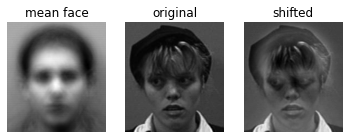

In [6]:
#Initialize a FacialRec object and display its mean face, plus an original image and its shifted face.
urmom = FacialRec()
plt.subplot(131)
plt.title("mean face")
show(urmom.mu)
plt.subplot(132)
plt.title("original")
show(urmom.F[:, 0])    #use the face at index zero of F
plt.subplot(133)
plt.title("shifted")
show(urmom.Fbar[:,0])

### Problem 3

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


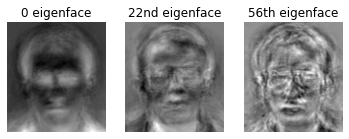

In [7]:
#display some of the eigenfaces (the columns of 𝑈)
plt.subplot(131)
plt.title("0 eigenface")
show(urmom.U[:,0])
plt.subplot(132)
plt.title("22nd eigenface")
show(urmom.U[:,22])
plt.subplot(133)
plt.title("56th eigenface")
show(urmom.U[:,56])

### Problem 4

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

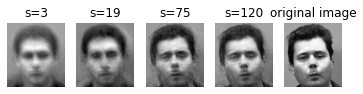

In [8]:
#Display each of the reconstructions and the original image of the image at index 25 of F
plt.subplot(151)
plt.title("s=3")
show((urmom.U[:,:3] @ urmom.project(urmom.F[:,25], 3)) + urmom.mu.flatten())
plt.subplot(152)
plt.title("s=19")
show((urmom.U[:,:19] @ urmom.project(urmom.F[:,25], 19)) + urmom.mu.flatten())
plt.subplot(153)
plt.title("s=75")
show((urmom.U[:,:75] @ urmom.project(urmom.F[:,25], 75)) + urmom.mu.flatten())
plt.subplot(154)
plt.title("s=120")
show((urmom.U[:,:120] @ urmom.project(urmom.F[:,25], 120)) + urmom.mu.flatten())
plt.subplot(155)
plt.title("original image")
show(urmom.F[:,25])

### Problem 5 
Implement `FacialRec.find_nearest()`.

### Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

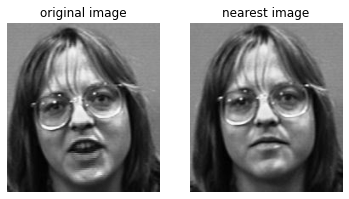

In [9]:
#Generate some random faces with sample_faces
comparisons = []
for test_image in sample_faces(5):
    comparisons.append(test_image)
#use FacialRec.match() to find the closest match for each face
urmom.match(comparisons[0])

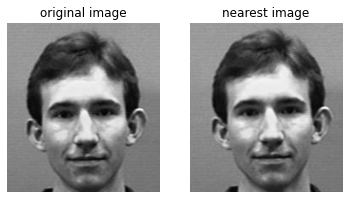

In [10]:
urmom.match(comparisons[1])

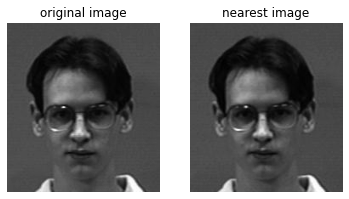

In [11]:
urmom.match(comparisons[2])

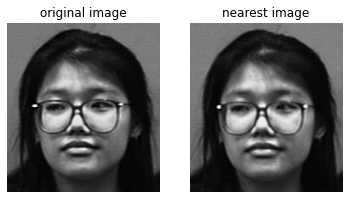

In [12]:
urmom.match(comparisons[3])

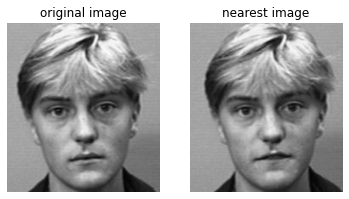

In [13]:
urmom.match(comparisons[4])